In [16]:
import torch
import torch.nn as nn
import torch.utils.data as data

from torch import Tensor
from torch.distributions import Bernoulli, Distribution, Independent, Normal, Uniform
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_pil_image, to_tensor
from tqdm import tqdm

import zuko

_ = torch.random.manual_seed(0)

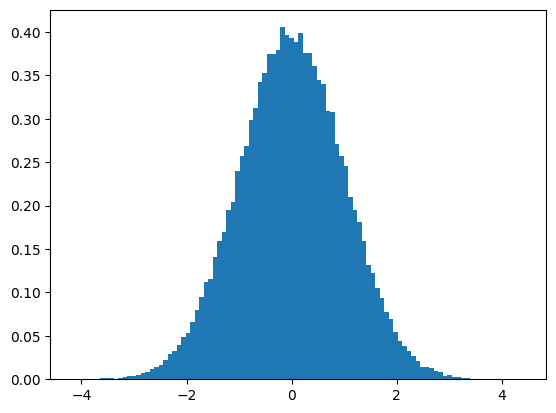

In [22]:
# generate 100000 samples from a 1D Gaussian

mu = torch.tensor([0.0])
sigma = torch.tensor([1.0])
normal = Normal(mu, sigma)
normal_samples = normal.sample((100000,))

# plot the histogram of the samples

import matplotlib.pyplot as plt
plt.hist(normal_samples.numpy(), bins=100, density=True)
plt.show()


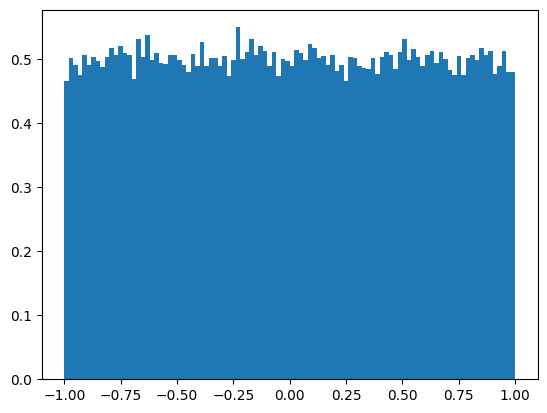

In [29]:
# create a uniform distribution

uniform = Uniform(-1.0, 1.0)
uniform_samples = uniform.sample((100000,))
uniform_samples = uniform_samples.unsqueeze(1)
plt.hist(uniform_samples.numpy(), bins=100, density=True)
plt.show()


In [30]:
# create a train dataloader from the samples

dataset = torch.cat([normal_samples, uniform_samples], dim=-1)
trainloader = data.DataLoader(dataset, batch_size=64, shuffle=True)
print(dataset.shape)

torch.Size([100000, 2])


In [51]:
flow = zuko.flows.NSF(features=1, context=1, transforms=3, hidden_features=(256, 256))
# print number of parameters
print(sum(p.numel() for p in flow.parameters()))
print(flow(torch.randn(1, 1)))

216645
NormalizingFlow(
  (transform): ComposedTransform(
    (0): DependentTransform(MonotonicRQSTransform(bins=8), 1)
    (1): DependentTransform(MonotonicRQSTransform(bins=8), 1)
    (2): DependentTransform(MonotonicRQSTransform(bins=8), 1)
  )
  (base): DiagNormal(loc: tensor([[0.]]), scale: tensor([[1.]]))
)


In [52]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for epoch in range(8):
    losses = []

    for x in trainloader:
        x, y = x.split([1, 1], dim=-1)
        #y_hat = flow(x)
        loss = -flow(x).log_prob(y).mean()
        #loss = -flow().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 0.7525021433830261 ± 0.0751950815320015
(1) 0.7175981998443604 ± 0.025762757286429405
(2) 0.7160289883613586 ± 0.024040669202804565
(3) 0.7120639085769653 ± 0.022832900285720825
(4) 0.7107819318771362 ± 0.021069666370749474
(5) 0.7106785178184509 ± 0.02300257794559002
(6) 0.7086082696914673 ± 0.02078089490532875
(7) 0.7073511481285095 ± 0.018751656636595726


torch.Size([1000000, 1])


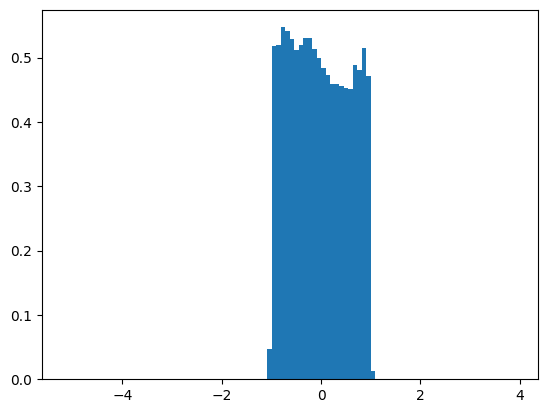

In [53]:
#samples = flow().sample((100000,))
samples = flow(torch.randn(1000000, 1)).sample()
print(samples.shape)
plt.hist(samples.detach().numpy(), bins=100, density=True)
plt.show()